# Analyse Interpolated PSF, Version 2 : Fixed scale to Max size


Analyse the Interpolate the PSF within the simulated ray grid at CTIO

- author : Sylvie Dagoret-Campagne
- affiliation : IJCLab/IN2P3/CNRS

- creation date : June 17th 2020

Purpose : Use the same scale for wavelengh and disperser

In [163]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
import matplotlib as mpl
import pandas as pd
import itertools
import matplotlib.gridspec as gridspec
from matplotlib.patches import Circle,Ellipse

import matplotlib.colors as colors
import matplotlib.cm as cmx
from matplotlib import cm

from matplotlib.ticker import FormatStrFormatter

In [164]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (13, 13),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large',
         'font.size': 14}
plt.rcParams.update(params)

In [165]:
from astropy.modeling import models, fitting
from astropy.modeling.models import custom_model

In [166]:
from scipy import interpolate
from scipy.optimize import curve_fit

In [167]:
from sklearn.neighbors import NearestNeighbors

In [168]:
from astropy.modeling import models, fitting
from astropy.modeling.models import custom_model

In [169]:
from datetime import datetime,date

In [170]:
today = date.today()
string_date=today.strftime("%Y-%m-%d")

##### scale bar
https://stackoverflow.com/questions/43258638/is-there-a-convenient-way-to-add-a-scale-indicator-to-a-plot-in-matplotlib

In [171]:
import matplotlib.offsetbox
from matplotlib.lines import Line2D

In [172]:
class AnchoredHScaleBar(matplotlib.offsetbox.AnchoredOffsetbox):
    """ size: length of bar in data units
        extent : height of bar ends in axes units """
    def __init__(self, size=1, extent = 0.03, label="", loc=2, ax=None,
                 pad=0.4, borderpad=0.5, ppad = 0, sep=2, prop=None, 
                 frameon=True, linekw={},textkw={} ,**kwargs):
        if not ax:
            ax = plt.gca()
        trans = ax.get_xaxis_transform()
        size_bar = matplotlib.offsetbox.AuxTransformBox(trans)
        line = Line2D([0,size],[0,0], **linekw)
        vline1 = Line2D([0,0],[-extent/2.,extent/2.], **linekw)
        vline2 = Line2D([size,size],[-extent/2.,extent/2.], **linekw)
        size_bar.add_artist(line)
        size_bar.add_artist(vline1)
        size_bar.add_artist(vline2)
        txt = matplotlib.offsetbox.TextArea(label, minimumdescent=False,textprops=textkw)
        self.vpac = matplotlib.offsetbox.VPacker(children=[size_bar,txt],  
                                 align="center", pad=ppad, sep=sep) 
        matplotlib.offsetbox.AnchoredOffsetbox.__init__(self, loc, pad=pad, 
                 borderpad=borderpad, child=self.vpac, prop=prop, frameon=frameon,
                 **kwargs)

## Constants for conversions

In [173]:
m_to_mm=1000.
mm_to_m=1e-3
mm_to_micr=1e3
inch_to_mm=25.4
mm_to_inch=1./inch_to_mm
mm_to_nm=1e6
micr_to_m=1e-6
micr_to_mm=1e-3
m_to_micr=1./micr_to_m
m_to_cm=100.
m_to_nm=1e9
nm_to_m=1./m_to_nm

In [174]:
arcdeg_to_arcmin=60.
arcmin_to_arcdeg=1./arcdeg_to_arcmin
arcmin_to_arcsec=60.
arcdeg_to_arcsec=arcdeg_to_arcmin*arcmin_to_arcsec
arcsec_to_arcdeg=1./arcdeg_to_arcsec

In [175]:
deg_to_rad=np.pi/180.

In [176]:
rad_to_deg=1./deg_to_rad
rad_to_arcsec=rad_to_deg*arcdeg_to_arcsec
rad_to_arcmin=rad_to_deg*arcdeg_to_arcmin
arcmin_to_rad=1./rad_to_arcmin

## Configuration parameters at the telescope

#### telescope

In [177]:
Tel_Focal_Length=12.6 # m : Focal length of the telescope
Tel_Diameter=0.9 # m : Diameter of the telescope    
Tel_Fnum=Tel_Focal_Length/Tel_Diameter
pltscale=206265/(Tel_Focal_Length*m_to_mm)  # arcsec per mm

In [178]:
print("plate_scale={:2.2f} arcsec per mm ".format(pltscale))

plate_scale=16.37 arcsec per mm 


In [179]:
print("1 arsec = {:2.2f} microns".format(1/pltscale*mm_to_micr))

1 arsec = 61.09 microns


In [180]:
1/pltscale*mm_to_micr/2.36*3

77.65228784593788

#### Seeing

diameter is taken to be FWHM

In [181]:
seeing_radius=1./pltscale/2. # in mm

In [182]:
seeing_radius*2*mm_to_micr

61.08646643880446

##### Diffraction at Hologram

$$
FWHM = \lambda \cdot \frac{f}{D} \cdot \frac{D}{D_{beam-holo}} =  \lambda \cdot \frac{f}{D} \cdot \frac{f}{D_{Holo-CCD}}
$$

##### Approximation by a Gaussian

https://en.wikipedia.org/wiki/Airy_disk

$$
\sigma = 0.45 \cdot \lambda \cdot \frac{f}{D}
$$

$$
FWHM = \lambda \cdot \frac{f}{D}
$$

##### Diffraction at Hologram

$$
FWHM = \lambda \cdot \frac{f}{D} \cdot \frac{D}{D_{beam-holo}} =  \lambda \cdot \frac{f}{D} \cdot \frac{f}{D_{Holo-CCD}}
$$

#### filter

In [183]:
Filt_D=0.05769 # m distance of the filter position wrt CCD plane
Filt_size=3*inch_to_mm

In [184]:
# Seeing :no unit, to be multiplied by wavelength say in mm units
diffr_FWHM_entrance_perwl=Tel_Fnum
diffr_FWHM_holo_perwl=Tel_Fnum/Filt_D

#### CCD detector

In [185]:
Det_xpic=24.0 # microns per pixel
#Det_NbPix=2048 # number of pixels per CCD side
Det_NbPix=2512 # number of pixels per CCD side For 400 only
Det_size=Det_xpic*Det_NbPix*micr_to_mm # CCD size in mm, 5 cm or 2 inch

## Input file

In [186]:
# number of rays
NBEAM_X=11
NBEAM_Y=11
NBEAM=NBEAM_X*NBEAM_Y
NWL=4
NBTOT=NBEAM*NWL

In [187]:
theta_x=0.  # angle in arcmin
theta_y=0.  # angle in arcmin 

In [188]:
theta_x_num=int(theta_x*10)
theta_y_num=int(theta_y*10)

In [189]:
if theta_x_num>0:
    theta_nstr='{:0>2}'.format(theta_x_num)
    theta_x_str="p"+theta_nstr
else:
    theta_nstr='{:0>2}'.format(-theta_x_num)
    theta_x_str="m"+theta_nstr

In [190]:
if theta_y_num>0:
    theta_nstr='{:0>2}'.format(theta_y_num)
    theta_y_str="p"+theta_nstr
else:
    theta_nstr='{:0>2}'.format(-theta_y_num)
    theta_y_str="m"+theta_nstr

In [191]:
Beam4_Rayfile="Beam4_Rayfile_{:d}_allwl_{}_{}".format(NBTOT,theta_x_str,theta_y_str)

In [192]:
Beam4_Rayfile

'Beam4_Rayfile_484_allwl_m00_m00'

In [193]:
order="OP1"
order_str="+1"

# Read input files

## resampled rays files

In [194]:
rayfile_R400="R400_RESAMPLEBEAM_Beam4_Rayfile_484_allwl_m00_m00_out.csv"
rayfile_HOE="HOE_RESAMPLEBEAM_Beam4_Rayfile_484_allwl_m00_m00_out.csv"

## reference optically simulated files

In [195]:
refrayfile_R400="R400_Beam4_Rayfile_484_allwl_m00_m00_2020_05_25_B4OUT_RAY.xlsx"
refrayfile_HOE="HOE_Beam4_Rayfile_484_allwl_m00_m00_2020_05_25_B4OUT_RAY.xlsx"

# Choose disperser

In [196]:
FLAG_R400 = True
FLAG_R300 = False
FLAG_R350 = False
FLAG_R200 = False
FLAG_HOE = False

In [197]:
Beam4_Rayfile

'Beam4_Rayfile_484_allwl_m00_m00'

In [198]:
if FLAG_R400:
    input_data_file=rayfile_R400
    input_data_reffile=refrayfile_R400
    disperser_name="Ronchi 400"
    disperser_tag="R400"
    
elif FLAG_R300:
    input_data_file=None
    
    
elif FLAG_R350:
    input_data_file=None
        
elif FLAG_R200:
    input_data_file=None
        
else:
    input_data_file=rayfile_HOE
    input_data_reffile=refrayfile_HOE
    disperser_name="Hologram"
    disperser_tag="HOE"
    

# Read Files

In [199]:
df=pd.read_csv(input_data_file)

In [200]:
input_ref = pd.ExcelFile(input_data_reffile)
df_ref = input_ref.parse(index_row=0,header=1)
df_ref=df_ref.iloc[0:NBTOT]

# Show beam at beginning of tracking

Text(0.5, 1.0, 'Simulated beam at start plane')

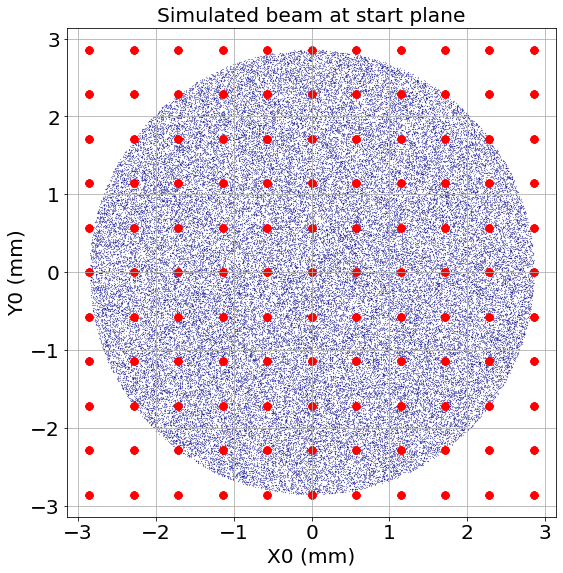

In [201]:
f, ax1 = plt.subplots(figsize=(9,9))
df.plot.scatter(x="X0", y="Y0",c="DarkBlue",marker=".",s=0.1,ax=ax1)
df_ref.plot.scatter(x="X0", y="Y0",c="red",marker="o",ax=ax1,s=50)
ax1.set_aspect("equal")
ax1.set(xlabel='X0 (mm)', ylabel='Y0 (mm)')
ax1.grid()
ax1.set_title("Simulated beam at start plane")

In [202]:
#NBEAMS=len(df)

## Wavelengths

In [203]:
WLSIM = np.array([0.0004,0.0006,0.0008,0.001])

In [204]:
idx_WLSEL=3
wlsim=WLSIM[idx_WLSEL]
wllabel="$\lambda = {:3.0f}$ nm".format(wlsim*mm_to_nm)

### Resampled beam

In [205]:
if idx_WLSEL==0:
    Xccd=df["Xccd_400"].values
    Yccd=df["Yccd_400"].values
elif idx_WLSEL==1:
    Xccd=df["Xccd_600"].values
    Yccd=df["Yccd_600"].values
elif idx_WLSEL==2:
    Xccd=df["Xccd_800"].values
    Yccd=df["Yccd_800"].values
elif idx_WLSEL==3:  
    Xccd=df["Xccd_1000"].values
    Yccd=df["Yccd_1000"].values

### Reference beam

In [206]:
df_ref=df_ref.loc[df_ref.wave==wlsim]

In [207]:
Xccdref=df_ref["X3"].values
Yccdref=df_ref["Y3"].values

### Central beam

In [208]:
central_beam=df_ref[(df_ref["X0"] == 0) & (df_ref["Y0"] == 0)]

In [209]:
X3C=central_beam["X3"].values[0]
Y3C=central_beam["Y3"].values[0]

### Upper-lower range

In [210]:
Xccrefmin=Xccdref.min()
Xccrefmax=Xccdref.max()

Yccrefmin=Yccdref.min()
Yccrefmax=Yccdref.max()

### Width

In [211]:
XWref=Xccrefmax-Xccrefmin
YWref=Yccrefmax-Yccrefmin

### Choose the scale for all plots

In [212]:
XSCALE=1.5
YSCALE=0.5

In [213]:
XMIN=X3C-XSCALE/2.
XMAX=X3C+XSCALE/2

YMIN=Y3C-YSCALE/2.
YMAX=Y3C+YSCALE/2

In [214]:
X0Circle=XMIN+1.*XSCALE/10
Y0Circle=YMAX-3*YSCALE/10

In [215]:
X0Text=XMAX-1.5*XSCALE/10
Y0Text=YMIN+3*YSCALE/10

In [216]:
diffr_FWHM_holo=diffr_FWHM_holo_perwl*wlsim

# PSF 2D

In [217]:
def ComputeFWHM(values,nbins=50,thetitle="fwhm",thexlabel="X (mm)",flagplot=False):
    """
    ComputeFWHM(values,nbins,flagplot)
    
    input arg :
       values : list of values
       nbins. : number of bins in the histogram
       flagplot : flag to plot the distribution
    """
    
    counts, bins =np.histogram(values,bins=nbins)
    
    # compute bin width
    binwidths=(np.roll(bins,-1)-bins)[:-1]
    binwidth=np.mean(binwidths)
    
    # find max
    idx_max=np.where(counts==counts.max())[0][0]
    count_max=counts[idx_max]
    counts_halfmax=count_max/2.
    
    # bins above half max
    topmost=np.where(counts>=counts_halfmax)[0]
    idx_min_fwhm=topmost[0]
    idx_max_fwhm=topmost[-1]
    
    # lower upper part
    min_fwhm=bins[idx_min_fwhm]+binwidth/2.
    max_fwhm=bins[idx_max_fwhm]+binwidth/2.
    
    #fwhm
    fwhm=max_fwhm-min_fwhm
    
    
    if flagplot:
        f, ax = plt.subplots(figsize=(10,5))
        
        ax.hist(bins[:-1]+binwidth/2., bins+binwidth/2., weights=counts,facecolor="red",density=False)
        ax.axhline(y=counts_halfmax)
        ax.axvline(x=min_fwhm,color="k")
        ax.axvline(x=max_fwhm,color="k")
        
        ax.grid()
        thetitle=thetitle+" = {:3.0f} $\mu m$".format(fwhm*1000)
        ax.set_title(thetitle)
        ax.set_xlabel(thexlabel)
        
    return fwhm
            

In [218]:
fwhmX=ComputeFWHM(Xccd,50,thetitle="fwhm X",thexlabel="X (mm)",flagplot=False)
fwhmY=ComputeFWHM(Yccd,50,thetitle="fwhm Y",thexlabel="Y (mm)",flagplot=False)

In [219]:
fwhm_txt="FWHM_x={:3.0f} $\mu$m \n FWHM_y={:3.0f} $\mu$m".format(fwhmX*mm_to_micr,fwhmY*mm_to_micr)

## Plot

<Figure size 720x576 with 0 Axes>

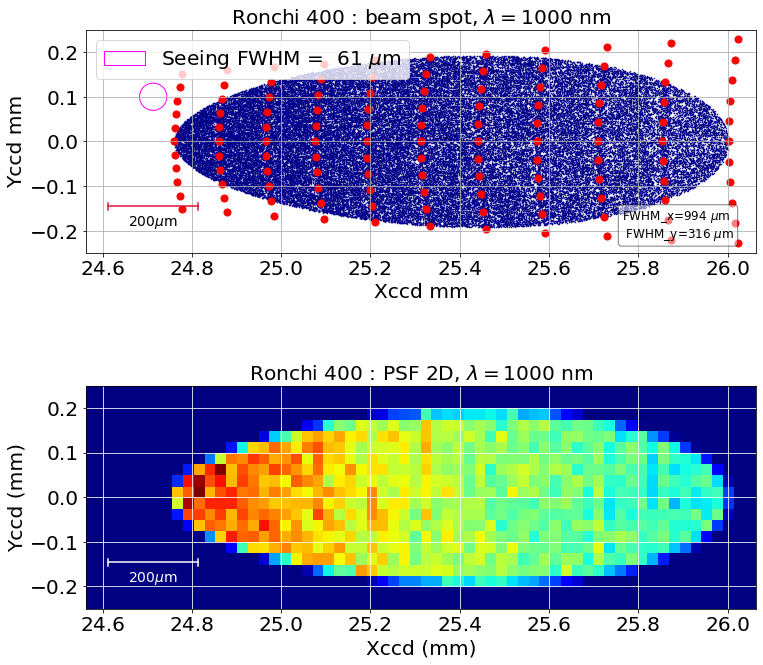

In [220]:
plt.figure(figsize=(10,8))
f, (ax1,ax2) = plt.subplots(2,1,figsize=(12,12))
#NBINX=(Xccd.max()-Xccd.min())/(Det_xpic*micr_to_mm)
#NBINY=(Yccd.max()-Yccd.min())/(Det_xpic*micr_to_mm) 

NBINX=XSCALE/(Det_xpic*micr_to_mm)
NBINY=YSCALE/(Det_xpic*micr_to_mm) 

NBINX=int(max(NBINX,1))
NBINY=int(max(NBINY,1))

ax1.scatter(Xccd,Yccd,marker="." ,color="DarkBlue",s=1)
ax1.scatter(Xccdref,Yccdref,marker="o" ,color="Red",s=50)

# draw seeing
circle1 = Circle((X0Circle,Y0Circle), seeing_radius, linewidth=1,edgecolor='magenta', facecolor=(0, 0, 0, .0125),label="seeing FWHM")
C1=ax1.add_artist(circle1)

# draw diffraction
#circle2 = Circle((X0Circle,Y0Circle), diffr_FWHM_holo/2, linewidth=1,edgecolor='green', facecolor=(0, 0, 0, .0125),label="diffraction FWHM")
#C2=ax1.add_artist(circle2)

ob = AnchoredHScaleBar(size=0.2, label="200$\mu$m", loc=3, frameon=False,
                       pad=0.6,sep=4, linekw=dict(color="crimson"),textkw=dict(color="black"),) 
ax1.add_artist(ob)

ax1.set_xlim(XMIN,XMAX)
ax1.set_ylim(YMIN,YMAX)

#ax1.legend([C1,C2],
#           ["Seeing FWHM = {:3.0f} $\mu$m".format(seeing_radius*2*mm_to_micr),"Diffraction FWHM = {:3.0f} $\mu$m".format(diffr_FWHM_holo*mm_to_micr)],fontsize=12)
ax1.legend([C1],
           ["Seeing FWHM = {:3.0f} $\mu$m".format(seeing_radius*2*mm_to_micr)])



ax1.grid()
ax1.set_aspect("equal")
ax1.set_xlabel("Xccd mm")
ax1.set_ylabel("Yccd mm")

#props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax1.text(0.8, 0.2, fwhm_txt, transform=ax1.transAxes, fontsize=12,verticalalignment='top', bbox=props)


title1="{} : beam spot, {}".format(disperser_name,wllabel)
ax1.set_title(title1)

ax2.hist2d(Xccd,Yccd,bins=(NBINX,NBINY),range=[[XMIN,XMAX],[YMIN,YMAX]],cmap=cm.get_cmap('jet'))
ob = AnchoredHScaleBar(size=0.2, label="200$\mu$m", loc=3, frameon=False,pad=0.6,sep=4, linekw=dict(color="white"),textkw=dict(color="white"),) 
ax2.add_artist(ob) 

#ax2.scatter(Xccdref,Yccdref,marker="o" ,color="k",s=50)
ax2.set_aspect("equal")
ax2.set_xlabel("Xccd (mm)")
ax2.set_ylabel("Yccd (mm)")
ax2.grid(b=True,color="white")

title2="{} : PSF 2D, {}".format(disperser_name,wllabel)
ax2.set_title(title2)
#ax2.grid(b=True,color="white")


figname="PSFSIM_2D_"+disperser_tag+"_WL"+str(idx_WLSEL)+"_v2.pdf"
plt.savefig(figname)

# FWHM

In [221]:
def ComputeFWHM(values,nbins=50,thetitle="fwhm",thexlabel="X (mm)",flagplot=False):
    """
    ComputeFWHM(values,nbins,flagplot)
    
    input arg :
       values : list of values
       nbins. : number of bins in the histogram
       flagplot : flag to plot the distribution
    """
    
    counts, bins =np.histogram(values,bins=nbins)
    
    # compute bin width
    binwidths=(np.roll(bins,-1)-bins)[:-1]
    binwidth=np.mean(binwidths)
    
    # find max
    idx_max=np.where(counts==counts.max())[0][0]
    count_max=counts[idx_max]
    counts_halfmax=count_max/2.
    
    # bins above half max
    topmost=np.where(counts>=counts_halfmax)[0]
    idx_min_fwhm=topmost[0]
    idx_max_fwhm=topmost[-1]
    
    # lower upper part
    min_fwhm=bins[idx_min_fwhm]+binwidth/2.
    max_fwhm=bins[idx_max_fwhm]+binwidth/2.
    
    #fwhm
    fwhm=max_fwhm-min_fwhm
    
    
    if flagplot:
        f, ax = plt.subplots(figsize=(10,5))
        
        ax.hist(bins[:-1]+binwidth/2., bins+binwidth/2., weights=counts,facecolor="red",density=False)
        ax.axhline(y=counts_halfmax)
        ax.axvline(x=min_fwhm,color="k")
        ax.axvline(x=max_fwhm,color="k")
        
        ax.grid()
        thetitle=thetitle+" = {:3.0f} $\mu m$".format(fwhm*1000)
        ax.set_title(thetitle)
        ax.set_xlabel(thexlabel)
        
    return fwhm
            

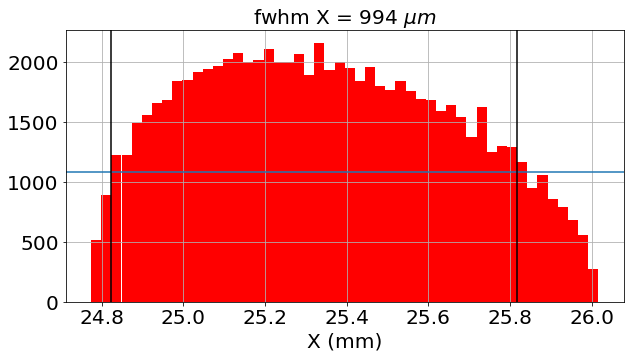

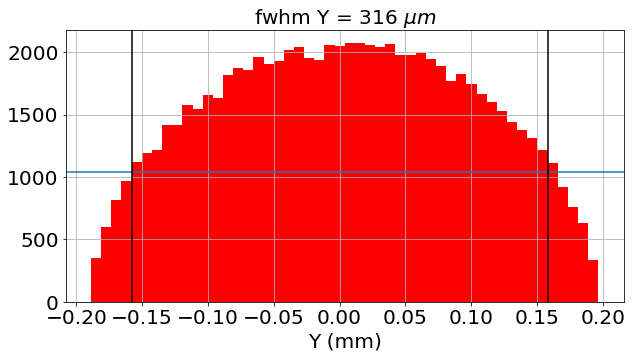

In [222]:
fwhmX=ComputeFWHM(Xccd,50,thetitle="fwhm X",thexlabel="X (mm)",flagplot=True)
fwhmY=ComputeFWHM(Yccd,50,thetitle="fwhm Y",thexlabel="Y (mm)",flagplot=True)

### histogram in CCD pixels

In [223]:


NBINSX=XSCALE/(Det_xpic*micr_to_mm)
NBINSY=YSCALE/(Det_xpic*micr_to_mm) 

NBINSX=int(max(NBINSX,1))
NBINSY=int(max(NBINSY,1))



# compute the histogram
h1=np.histogram(Xccd,bins=NBINSX,range=(XMIN,XMAX))
h2=np.histogram(Yccd,bins=NBINSY,range=(YMIN,YMAX))


counts1, bins1 = h1
counts2, bins2 = h2

# compute bin width
# compute bin width
binwidths1=(np.roll(bins1,-1)-bins1)[:-1]
binwidth1=np.mean(binwidths1)

binwidths2=(np.roll(bins2,-1)-bins2)[:-1]
binwidth2=np.mean(binwidths2)

# What to fit

theX1=(bins1+binwidth1/2)[:-1]
theY1=counts1

theX2=(bins2+binwidth2/2)[:-1]
theY2=counts2

<Figure size 864x720 with 0 Axes>

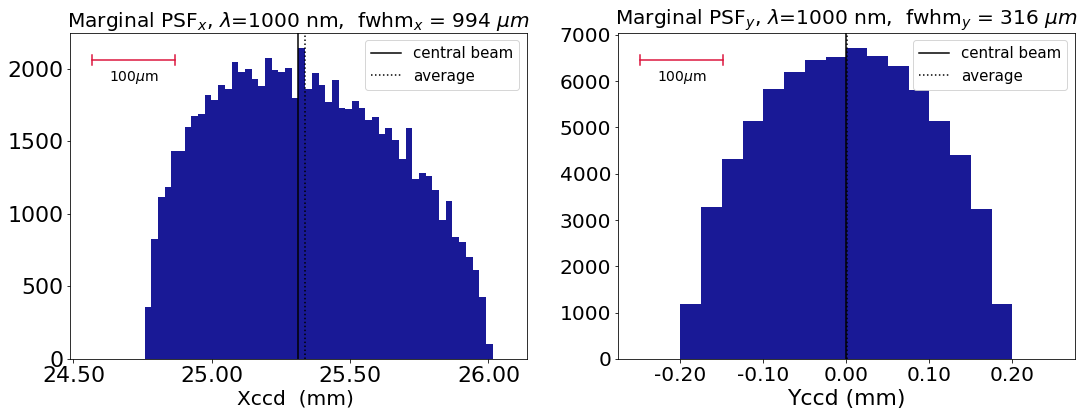

In [224]:
plt.figure(figsize=(12,10))
f, (ax1,ax2) = plt.subplots(1,2,figsize=(18,6))


# in X
#ax1.hist(Xccd,bins=NBINSX,facecolor="blue")
ax1.hist(bins1[:-1], bins1, weights=counts1,facecolor="DarkBlue",density=False,alpha=0.9)
ax1.set_xlabel("Xccd  (mm) ")
ax1.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax1.tick_params(labelsize=22)
title1= "Marginal PSF$_x$, $\lambda$={:3.0f} nm,  fwhm$_x$ = {:3.0f} $\mu m$".format(wlsim*mm_to_nm,fwhmX*1000)
ax1.set_title(title1)
ax1.axvline(x=X3C,color="k",label="central beam")
ax1.axvline(x=Xccd.mean(),linestyle=":",color="k",label="average")
# scale bar
ob = AnchoredHScaleBar(size=0.1, label="100$\mu$m", loc=2, frameon=False,pad=0.6,sep=4, linekw=dict(color="crimson"),textkw=dict(color="black")) 
ax1.add_artist(ob)   
ax1.legend(fontsize=15)


# in Y
#ax2.hist(Yccd,bins=NBINSY,facecolor="blue")
ax2.hist(bins2[:-1], bins2, weights=counts2,facecolor="DarkBlue",density=False,alpha=0.9)

ax2.set_xlabel("Yccd (mm)")
ax2.set_xlabel("Yccd (mm)",fontsize=22)
ax2.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
title2= "Marginal PSF$_y$, $\lambda$={:3.0f} nm,  fwhm$_y$ = {:3.0f} $\mu m$".format(wlsim*mm_to_nm,fwhmY*1000)
ax2.set_title(title2)
ax2.axvline(x=Y3C,color="k",label="central beam")
ax2.axvline(x=Yccd.mean(),linestyle=":",color="k",label="average")
ax2.legend(fontsize=15)
ob = AnchoredHScaleBar(size=0.1, label="100$\mu$m", loc=2, frameon=False,pad=0.6,sep=4, linekw=dict(color="crimson"),textkw=dict(color="black")) 
ax2.add_artist(ob)  


figname="PSFSIM_1D_"+disperser_tag+"_WL"+str(idx_WLSEL)+"_v2.pdf"
plt.savefig(figname)

# Fit

## Prepare data for the fit

In [225]:
Xpos=Xccd
Ypos=Yccd

NBINS=50

RX=Xpos.max()-Xpos.mean()
RY=Ypos.max()-Ypos.mean()

# compute the histogram
h1=np.histogram(Xpos,bins=NBINS)
h2=np.histogram(Ypos,bins=NBINS)
counts1, bins1 = h1
counts2, bins2 = h2

# compute bin width
binwidths1=(np.roll(bins1,-1)-bins1)[:-1]
binwidth1=np.mean(binwidths1)

binwidths2=(np.roll(bins2,-1)-bins2)[:-1]
binwidth2=np.mean(binwidths2)

# What to fit
theX1=(bins1+binwidth1/2)[:-1]
theY1=counts1

theX2=(bins2+binwidth2/2)[:-1]
theY2=counts2

## Scipy fit

### Models

#### Disk model

In [226]:
def disk1D(x,a=10.,b=10.,c=0.):
    """
    R=b
    c=x0
    f(x)=a/pi/R*sqrt(1-x**2/R**2)
    """
    R=b
    x0=c
    
    if R<0:
        return 0
    
    D=(x-x0)**2/R**2
    
    
    funct=np.where(D<1.,a/np.pi*np.sqrt(1.-D),0)
    
    return funct

## Fit X

### Init fit parameters

In [227]:
Ainit1=len(Xpos)/NBINS*4
Binit1=RX
Cinit1=Xpos.mean()

### Do the fit

In [228]:
popt, pcov = curve_fit(disk1D, theX1, theY1,p0=(Ainit1,Binit1,Cinit1))

/Users/dagoret/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in sqrt
  app.launch_new_instance()


In [229]:
Afit1=popt[0]
Bfit1=popt[1]
Cfit1=popt[2]

### Show the result

In [230]:
Xfit1=np.linspace(Cinit1-RX*1.2,Cinit1+RX*1.2,50)
Yfit1=disk1D(Xfit1,a=Afit1, b=Bfit1, c=Cfit1)

/Users/dagoret/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in sqrt
  app.launch_new_instance()


In [231]:
textstr = '\n'.join((
    r'$a=%.0f$' % (Afit1, ),
    r'$R=%.3f$' % (Bfit1, ),
    r'$x0=%.3f$' % (Cfit1, )))

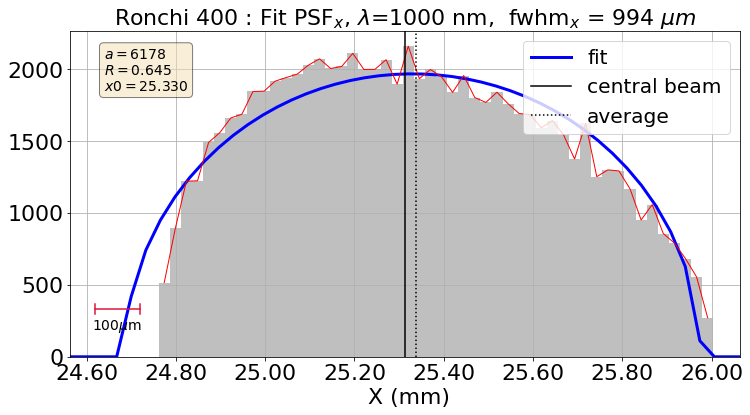

In [232]:
f, ax = plt.subplots(figsize=(12,6))
ax.hist(bins1[:-1], bins1, weights=counts1,facecolor="grey",alpha=0.5,density=False)
ax.plot(Xfit1,Yfit1,"b",lw=3,label="fit")
ax.plot(theX1,theY1,"r-",lw=1)
ax.axvline(x=X3C,color="k",label="central beam")
ax.axvline(x=Xccd.mean(),linestyle=":",color="k",label="average")
ax.set_xlabel(" X (mm)",fontsize=22)
ax.tick_params(labelsize=22)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
title= "{} : Fit PSF$_x$, $\lambda$={:3.0f} nm,  fwhm$_x$ = {:3.0f} $\mu m$".format(disperser_name,wlsim*mm_to_nm,fwhmX*1000)
ax.set_title(title,fontsize=22)
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
# place a text box in upper left in axes coords
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,verticalalignment='top', bbox=props)
ax.legend(loc="upper right")
ax.grid()
ax.set_xlim(XMIN,XMAX)
# scale bar
ob = AnchoredHScaleBar(size=0.1, label="100$\mu$m", loc=3, frameon=False,pad=0.6,sep=4, linekw=dict(color="crimson"),textkw=dict(color="black")) 
ax.add_artist(ob) 
figname="FITPSFSIMX_1D_"+disperser_tag+"_WL"+str(idx_WLSEL)+"_v2.pdf"
plt.savefig(figname)

## Fit Y

### Init Fit parameters

In [233]:
Ainit2=len(Ypos)/NBINS*4
Binit2=RY
Cinit2=Ypos.mean()

### Do the fit

In [234]:
popt, pcov = curve_fit(disk1D, theX2, theY2,p0=(Ainit2,Binit2,Cinit2))

In [235]:
Afit2=popt[0]
Bfit2=popt[1]
Cfit2=popt[2]

### Plot the result

In [236]:
Xfit2=np.linspace(Cinit2-RY*1.2,Cinit2+RY*1.2,50)
Yfit2=disk1D(Xfit2,a=Afit2, b=Bfit2, c=Cfit2)

/Users/dagoret/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in sqrt
  app.launch_new_instance()


In [237]:
textstr = '\n'.join((
    r'$a=%.0f$' % (Afit2, ),
    r'$R=%.3f$' % (Bfit2, ),
    r'$x0=%.3f$' % (Cfit2, )))

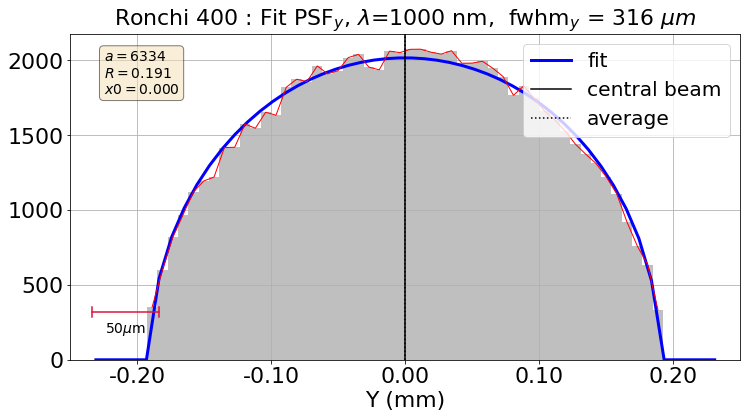

In [239]:
f, ax = plt.subplots(figsize=(12,6))
ax.hist(bins2[:-1], bins2, weights=counts2,facecolor="grey",alpha=0.5,density=False)
ax.plot(Xfit2,Yfit2,"b",lw=3,label="fit")
ax.plot(theX2,theY2,"r-",lw=1)
ax.axvline(x=Y3C,color="k",label="central beam")
ax.axvline(x=Yccd.mean(),linestyle=":",color="k",label="average")
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
# place a text box in upper left in axes coords
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,verticalalignment='top', bbox=props)
ax.legend(loc="upper right")
ax.set_xlabel("Y (mm)",fontsize=22)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
#ax.tick_params(axis='x', labelsize=25)
ax.tick_params(labelsize=22)
title= "{} : Fit PSF$_y$, $\lambda$={:3.0f} nm,  fwhm$_y$ = {:3.0f} $\mu m$".format(disperser_name,wlsim*mm_to_nm,fwhmY*1000)
ax.set_title(title,fontsize=22)
ax.grid()
ax.set_xlim(YMIN,YMAX)
# scale bar
ob = AnchoredHScaleBar(size=0.05, label="50$\mu$m", loc=3, frameon=False,pad=0.6,sep=4, linekw=dict(color="crimson"),textkw=dict(color="black")) 
ax.add_artist(ob) 
figname="FITPSFSIMY_1D_"+disperser_tag+"_WL"+str(idx_WLSEL)+"_v2.pdf"
plt.savefig(figname)